# Ac-225 Advanced PSF Modeling (DICOM)

This tutorial uses the PSF operators obtained using the SPECTPSF toolbox to reconstruct Ac225 data. The operator was obtained using tutorial 5, available at this [link](https://github.com/lukepolson/SPECTPSFToolbox/blob/main/tutorials/5_optimization_ac225.ipynb). Use of this operator requires the SPECTPSFToolbox to be installed; instructions for installing can be found on the README [here](https://github.com/lukepolson/SPECTPSFToolbox/tree/main)

In [1]:
import matplotlib.pyplot as plt
import torch # needed for kernels
import pytomography
from pytomography.projectors.SPECT import SPECTSystemMatrix
from pytomography.io.SPECT import dicom
from pytomography.algorithms import OSEM
from pytomography.likelihoods import PoissonLogLikelihood
from pytomography.transforms.SPECT import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.transforms.shared import GaussianFilter
from pytomography.io.SPECT.shared import subsample_projections_and_modify_metadata
import dill
import os
from pytomography.utils import plot_utils

Tutorial data path

In [2]:
path  = '/mnt/mydisk2/pytomo_tutorial_data/SPECT'

Location of files

In [3]:
pathCT = os.path.join(path, 'Ac225-NEMA-SymT2', 'CT')
files_CT = [os.path.join(pathCT, file) for file in os.listdir(pathCT)]
file_NM = os.path.join(path, 'Ac225-NEMA-SymT2', 'projection_data.IMA')

Open the PSF operator created in [this tutorial](https://github.com/lukepolson/SPECTPSFToolbox/blob/main/tutorials/5_optimization_ac225.ipynb)

In [4]:
with open(os.path.join(path, 'Ac225-NEMA-SymT2', 'ac225_psf_operator.pkl'), 'rb') as f:
    psf_operator = dill.load(f)
    psf_operator.set_device(pytomography.device)
    # Note that you may need to create this operator yourself with the SPECTPSFToolbox to match your GPU architecture

Define the peak, lower, and upper indices

In [5]:
index_peak = 3
index_lower = 4
index_upper = 5
object_meta, proj_meta = dicom.get_metadata(file_NM, index_peak=index_peak)
projections = dicom.get_projections(file_NM)
attenuation_map = dicom.get_attenuation_map_from_CT_slices(files_CT, file_NM, index_peak=index_peak)

Given photopeak energy 440.0 keV and CT energy 130 keV from the CT DICOM header, the HU->mu conversion from the following configuration is used: 440.0 keV SPECT energy, 130 keV CT energy, and scanner model symbiat2


Lets get the photopeak and scatter

In [6]:
photopeak = projections[index_peak]
scatter = dicom.get_energy_window_scatter_estimate_projections(file_NM, projections, index_peak=index_peak, index_lower=index_lower, index_upper=index_upper, sigma_theta=2, sigma_r=0.48, sigma_z=0.48, proj_meta=proj_meta)

Define system matrix

In [7]:
att_transform = SPECTAttenuationTransform(attenuation_map=attenuation_map)
psf_transform = SPECTPSFTransform(psf_operator=psf_operator)
system_matrix = SPECTSystemMatrix(
        obj2obj_transforms = [att_transform,psf_transform],
        proj2proj_transforms = [],
        object_meta = object_meta,
        proj_meta = proj_meta)

Define likelihood and algorithm

In [8]:
likelihood = PoissonLogLikelihood(system_matrix, photopeak, scatter)
algorithm = OSEM(likelihood)

Reconstruct using OSEM with 3 subsets (32 projections per subset)

In [9]:
recon = algorithm(n_iters=100, n_subsets=3)

Smooth the reconstructed image using a Gaussian filter with FWHM of 2cm.

In [10]:
filter = GaussianFilter(2) # 2cm FWHM
filter.configure(object_meta, proj_meta)
recon_smoothed = filter(recon)

Show an axial slice of the smoothed reconstruction. We'll also show the attenuation map in the background. We'll use the `plot_utils` section of the library

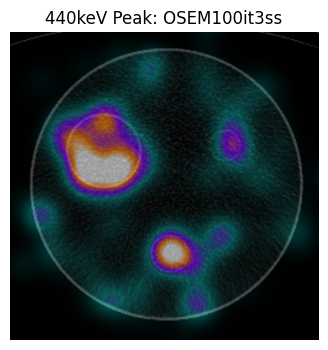

In [11]:
CT = dicom.open_multifile(files_CT)
affine_SPECT = dicom._get_affine_spect_projections(file_NM)
affine_CT = dicom._get_affine_multifile(files_CT)
SPECT_imshow_kwargs = {
    'cmap': plot_utils.pet_cmap,
    'interpolation': 'Gaussian',
    'alpha': 0.6,
    'vmin': 0,
    'vmax': 0.1,
    'zorder': 1, # this will ensure SPECT is on top of CT
    'origin': 'lower'
}
CT_imshow_kwargs = {
    'cmap': 'Greys_r',
    'interpolation': 'Gaussian',
    'vmin': -25, # HU
    'vmax': 300, # HU
    'zorder': 0,
    'origin': 'lower'
}

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title('440keV Peak: OSEM100it3ss')
plot_utils.dual_imshow_axial(
    im1 = recon_smoothed,
    im2 = CT,
    im1_idx = 70,
    affine1 = affine_SPECT,
    affine2 = affine_CT,
    imshow1_kwargs=SPECT_imshow_kwargs,
    imshow2_kwargs=CT_imshow_kwargs,
)
plt.axis('off')
plt.xlim(-120,130)
plt.ylim(-275,-25)
plt.show()

Activity can be seen in the largest sphere, which is of 60mm diameter. The smaller sphere at the bottom, which is of diameter 37mm, also appears to have some counts. The SPECT reconstructions are of poor quality since there is so little data collected in standard Ac225 protocols. See our paper https://ieeexplore.ieee.org/document/10964321 for estimating uncertainty in these spheres